In [1]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_fscore_support, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm

# Load the dataset
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

In [2]:
# %%
# Select relevant columns
columns = ['sex', 'age', 'hours_to_hospital', 'kts', 'initialdec', 'mechofinj_str']
data = data[columns]

# Convert 'sex' to categorical
data['sex'] = data['sex'].map({1: 'Male', 2: 'Female'}).fillna('Unknown')

# Convert 'initial_dec' to categorical with appropriate labels
data['initialdec'] = data['initialdec'].map({
    1: 'Treat and send home',
    2: 'Take to theatre',
    3: 'N/A (died)',
    4: 'Admit to hospital ward'
}).fillna('Unknown')

# Filter out 'Send to' and 'Unknown' from 'initialdec'
data = data[~data['initialdec'].isin(['Send to', 'Unknown'])]

# Ensure no NaN values remain in categorical columns
data['sex'] = data['sex'].astype(str).fillna('Unknown')
data['mechofinj_str'] = data['mechofinj_str'].astype(str).fillna('Unknown')

# Select features and target variable
features = ['age', 'sex', 'hours_to_hospital', 'mechofinj_str']
target = 'initialdec'

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age', 'hours_to_hospital']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sex', 'mechofinj_str'])
    ])

# Split data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Load best hyperparameters from CSV
best_params_df = pd.read_csv("best_hyperparameters.csv", index_col=0)
best_params_dict = best_params_df.to_dict(orient='index')

In [3]:
# Create classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=best_params_dict['Logistic Regression']['classifier__C']),
    'Random Forest': RandomForestClassifier(
        n_estimators=int(best_params_dict['Random Forest']['classifier__n_estimators']),
        max_depth=int(best_params_dict['Random Forest']['classifier__max_depth']),
        min_samples_split=int(best_params_dict['Random Forest']['classifier__min_samples_split']),
        min_samples_leaf=int(best_params_dict['Random Forest']['classifier__min_samples_leaf']),
        bootstrap=best_params_dict['Random Forest']['classifier__bootstrap'] == 'True'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=int(best_params_dict['Gradient Boosting']['classifier__n_estimators']),
        learning_rate=best_params_dict['Gradient Boosting']['classifier__learning_rate'],
        max_depth=int(best_params_dict['Gradient Boosting']['classifier__max_depth']),
        min_samples_split=int(best_params_dict['Gradient Boosting']['classifier__min_samples_split']),
        min_samples_leaf=int(best_params_dict['Gradient Boosting']['classifier__min_samples_leaf'])
    ),
    'Support Vector Machine': SVC(
        probability=True,
        C=best_params_dict['Support Vector Machine']['classifier__C'],
        kernel=best_params_dict['Support Vector Machine']['classifier__kernel'],
        degree=int(best_params_dict['Support Vector Machine']['classifier__degree']),
        gamma=best_params_dict['Support Vector Machine']['classifier__gamma']
    )
}

results = []
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

Classifier: Logistic Regression
Accuracy: 0.6300914380714879
Confusion Matrix:
 [[  5   1   0   1]
 [  0 156   5  93]
 [  0   3 320 107]
 [  0  66 169 277]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00      0.71      0.83         7
            N/A (died)       0.69      0.61      0.65       254
       Take to theatre       0.65      0.74      0.69       430
   Treat and send home       0.58      0.54      0.56       512

              accuracy                           0.63      1203
             macro avg       0.73      0.65      0.68      1203
          weighted avg       0.63      0.63      0.63      1203

CV Mean Accuracy: 0.6268, CV Std: 0.0195, CV 95% CI: (0.6191719481520589, 0.6344910230093012)
CV Mean AUC-ROC: 0.7920, CV Std: 0.0111, CV 95% CI: (0.7876369032787931, 0.7963479890975773)
------------------------------
Classifier: Random Forest
Accuracy: 0.6882793017456359
Confusion Matrix:
 [[  6   1   

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


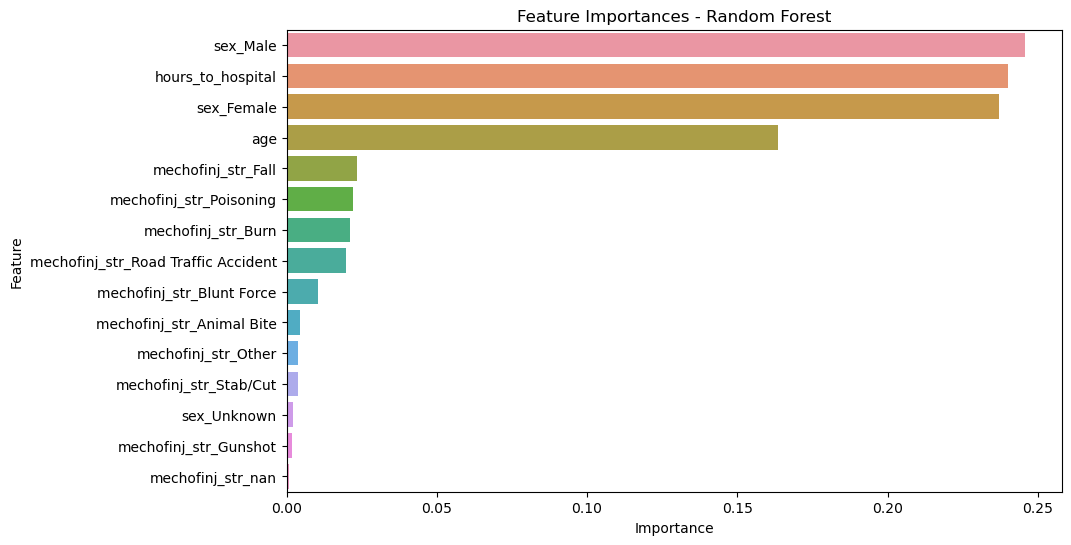

Classifier: Gradient Boosting
Accuracy: 0.6807980049875312
Confusion Matrix:
 [[  6   1   0   0]
 [  1 172   6  75]
 [  0   4 358  68]
 [  1  75 153 283]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       0.75      0.86      0.80         7
            N/A (died)       0.68      0.68      0.68       254
       Take to theatre       0.69      0.83      0.76       430
   Treat and send home       0.66      0.55      0.60       512

              accuracy                           0.68      1203
             macro avg       0.70      0.73      0.71      1203
          weighted avg       0.68      0.68      0.68      1203

CV Mean Accuracy: 0.6735, CV Std: 0.0140, CV 95% CI: (0.6680472381838866, 0.6790160648568885)
CV Mean AUC-ROC: 0.8285, CV Std: 0.0070, CV 95% CI: (0.8258049325158481, 0.8312677099949171)
------------------------------


/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


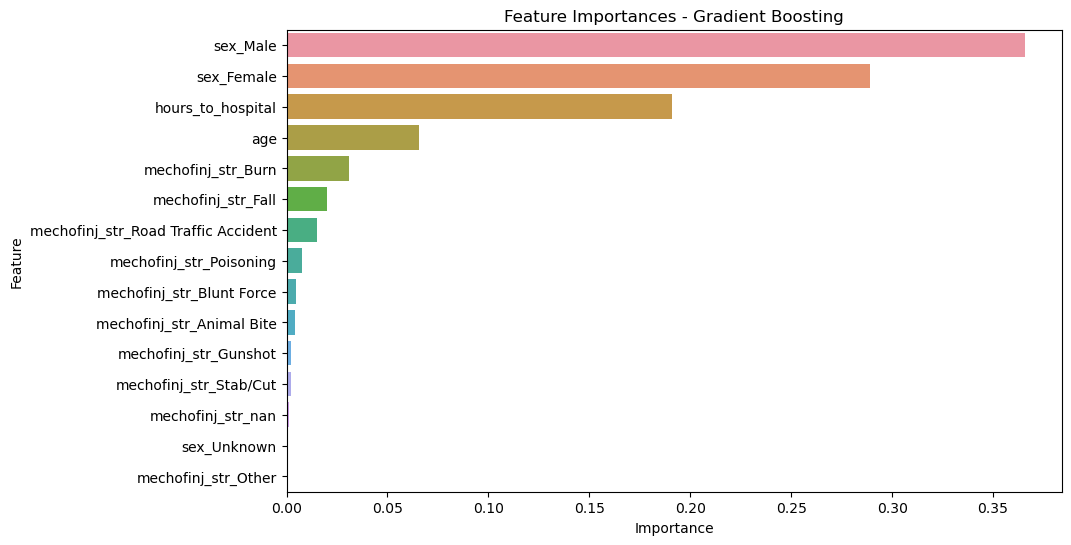

Classifier: Support Vector Machine
Accuracy: 0.686616791354946
Confusion Matrix:
 [[  5   2   0   0]
 [  0 183   6  65]
 [  0   5 371  54]
 [  0  86 159 267]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00      0.71      0.83         7
            N/A (died)       0.66      0.72      0.69       254
       Take to theatre       0.69      0.86      0.77       430
   Treat and send home       0.69      0.52      0.59       512

              accuracy                           0.69      1203
             macro avg       0.76      0.70      0.72      1203
          weighted avg       0.69      0.69      0.68      1203

CV Mean Accuracy: 0.6680, CV Std: 0.0039, CV 95% CI: (0.6664492587158926, 0.669543468579477)
CV Mean AUC-ROC: 0.7981, CV Std: 0.0072, CV 95% CI: (0.795289666779473, 0.8009319567891967)
------------------------------


In [4]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1_score

# Train, evaluate classifiers, and calculate CIs for both accuracy and AUC-ROC
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = []
    auc_cv_results = []
    for _ in range(5):
        scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
        cv_results.extend(scores)
        
        auc_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc_ovr_weighted')
        auc_cv_results.extend(auc_scores)
    
    cv_mean = np.mean(cv_results)
    cv_std = np.std(cv_results)
    cv_conf_interval = (cv_mean - 1.96*cv_std/np.sqrt(len(cv_results)), cv_mean + 1.96*cv_std/np.sqrt(len(cv_results)))
    
    auc_cv_mean = np.mean(auc_cv_results)
    auc_cv_std = np.std(auc_cv_results)
    auc_cv_conf_interval = (auc_cv_mean - 1.96*auc_cv_std/np.sqrt(len(auc_cv_results)), auc_cv_mean + 1.96*auc_cv_std/np.sqrt(len(auc_cv_results)))
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_prob = pipeline.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1_score = calculate_metrics(y_test, y_pred)
    
    # Compute ROC curve and ROC area
    y_test_bin = label_binarize(y_test, classes=pipeline.classes_)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    roc_auc_dict[name] = roc_auc

    results.append((name, accuracy, precision, recall, f1_score, roc_auc, cv_mean, cv_std, cv_conf_interval, auc_cv_mean, auc_cv_std, auc_cv_conf_interval))
    
    print(f'Classifier: {name}')
    print('Accuracy:', accuracy)
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print(f'CV Mean Accuracy: {cv_mean:.4f}, CV Std: {cv_std:.4f}, CV 95% CI: {cv_conf_interval}')
    print(f'CV Mean AUC-ROC: {auc_cv_mean:.4f}, CV Std: {auc_cv_std:.4f}, CV 95% CI: {auc_cv_conf_interval}')
    print('-'*30)

    # Feature importance for tree-based models
    if hasattr(clf, 'feature_importances_'):
        feature_importances = pipeline.named_steps['classifier'].feature_importances_
        feature_names = preprocessor.transformers_[0][1].named_steps['scaler'].get_feature_names_out(['age', 'hours_to_hospital']).tolist() + \
                        preprocessor.transformers_[1][1].get_feature_names_out(['sex', 'mechofinj_str']).tolist()
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importances - {name}')
        plt.show()

# %%

In [5]:
# Determine the model with the highest accuracy
best_model = max(results, key=lambda x: x[1])
print(f'Best Model: {best_model}')

# Create a table for the results
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'CV Mean Accuracy', 'CV Std', 'CV 95% CI', 'CV Mean AUC-ROC', 'CV Std AUC-ROC', 'CV 95% CI AUC-ROC'])
print(results_df)

# Save best hyperparameters
#best_params_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
#best_params_df.to_csv("best_hyperparameters_2.csv")


Best Model: ('Random Forest', 0.6882793017456359, 0.6866928100212543, 0.6882793017456359, 0.6836349697534905, 0.9094133374423921, 0.6754808359874346, 0.008160109996852096, (0.6722820728686686, 0.6786795991062006), 0.8214098597799591, 0.007676975264157638, (0.8184004854764093, 0.8244192340835088))
               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
0     Logistic Regression  0.630091   0.629736  0.630091  0.627832  0.893932   
1           Random Forest  0.688279   0.686693  0.688279  0.683635  0.909413   
2       Gradient Boosting  0.680798   0.678722  0.680798  0.675260  0.909114   
3  Support Vector Machine  0.686617   0.687614  0.686617  0.678296  0.901178   

   CV Mean Accuracy    CV Std                                 CV 95% CI  \
0          0.626831  0.019540  (0.6191719481520589, 0.6344910230093012)   
1          0.675481  0.008160  (0.6722820728686686, 0.6786795991062006)   
2          0.673532  0.013991  (0.6680472381838866, 0.6790160648568885)   
3

In [35]:
results_df.to_csv("final_results.csv")

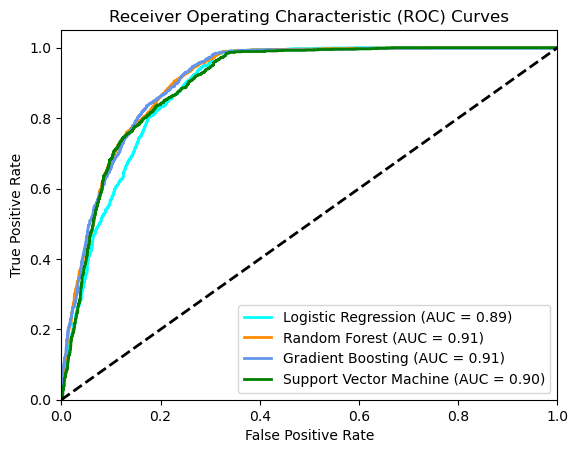

In [6]:
# %%
# Plotting the ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for (name, color) in zip(classifiers.keys(), colors):
    plt.plot(fpr_dict[name], tpr_dict[name], color=color, lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


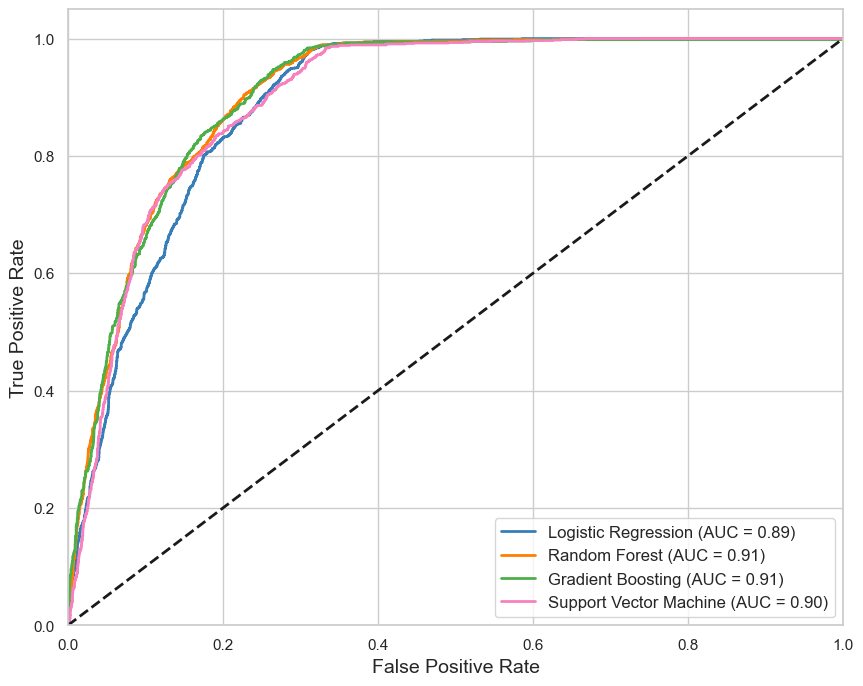

In [31]:
# Plotting the ROC curves
plt.figure(figsize=(10, 8))  # Increase figure size
colors = cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf'])  # Use a colorblind-friendly palette

for (name, color) in zip(classifiers.keys(), colors):
    plt.plot(fpr_dict[name], tpr_dict[name], color=color, lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
#plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
#plt.grid(True)  # Add grid lines
plt.show()

In [7]:
# %%
# Analyze relationship between KTS and admission decision
contingency_table = pd.crosstab(data['kts'], data['initialdec'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-squared Test:")
print(f"Chi2: {chi2}, p-value: {p}")

Chi-squared Test:
Chi2: 243.66248788713608, p-value: 2.9666614232860466e-38


In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd


# Convert 'initialdec' to numerical categories for logistic regression
data['initialdec_num'] = data['initialdec'].map({
    'Treat and send home': 0,
    'Take to theatre': 1,
    'N/A (died)': 2,
    'Admit to hospital ward': 3
})

# Drop rows with NaN values in 'kts' or 'initialdec_num'
data_clean = data.dropna(subset=['kts', 'initialdec_num'])

# Define the predictor and response variables for multinomial logistic regression
X_kts_logit_clean = sm.add_constant(data_clean[['kts']])  # Add constant term for intercept
y_initialdec_logit_clean = data_clean['initialdec_num']

# Initialize the logistic regression model for multinomial classification
mnlogit_model_cv = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Define the cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions for each fold
y_pred_cv = cross_val_predict(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf)

# Calculate the metrics for cross-validated predictions
accuracy_kts = accuracy_score(y_initialdec_logit_clean, y_pred_cv)
precision_kts = precision_score(y_initialdec_logit_clean, y_pred_cv, average='weighted')
recall_kts = recall_score(y_initialdec_logit_clean, y_pred_cv, average='weighted')
f1_score_kts = f1_score(y_initialdec_logit_clean, y_pred_cv, average='weighted')

# Proper label binarization for ROC-AUC calculation
lb = LabelBinarizer()
y_initialdec_bin = lb.fit_transform(y_initialdec_logit_clean)
y_pred_prob_cv = cross_val_predict(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf, method='predict_proba')

# Calculate ROC-AUC score using properly binarized labels
roc_auc_kts = roc_auc_score(y_initialdec_bin, y_pred_prob_cv, multi_class='ovr')

# Calculate mean, standard deviation, and confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    std_err = std / np.sqrt(len(data))
    h = std_err * 1.96
    return mean, std, mean - h, mean + h

# Scores for accuracy and other metrics
accuracy_scores = cross_val_score(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf, scoring='accuracy')
precision_scores = cross_val_score(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf, scoring=make_scorer(precision_score, average='weighted'))
recall_scores = cross_val_score(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf, scoring=make_scorer(recall_score, average='weighted'))
f1_scores = cross_val_score(mnlogit_model_cv, X_kts_logit_clean, y_initialdec_logit_clean, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

# Calculate mean, standard deviation, and confidence intervals
accuracy_mean, accuracy_std, accuracy_ci_lower, accuracy_ci_upper = mean_confidence_interval(accuracy_scores)
precision_mean, precision_std, precision_ci_lower, precision_ci_upper = mean_confidence_interval(precision_scores)
recall_mean, recall_std, recall_ci_lower, recall_ci_upper = mean_confidence_interval(recall_scores)
f1_mean, f1_std, f1_ci_lower, f1_ci_upper = mean_confidence_interval(f1_scores)

# Create a DataFrame for the KTS model performance
kts_results = pd.DataFrame({
    'Classifier': ['KTS Score'],
    'Accuracy': [accuracy_kts],
    'Precision': [precision_kts],
    'Recall': [recall_kts],
    'F1-Score': [f1_score_kts],
    'AUC-ROC': [roc_auc_kts],
    'CV Mean Accuracy': [accuracy_mean],
    'CV Std': [accuracy_std],
    'CV 95% CI': [(accuracy_ci_lower, accuracy_ci_upper)],
    'CV Mean AUC-ROC': [roc_auc_kts],  # Using overall ROC-AUC score for CV Mean
    'CV Std AUC-ROC': [np.std(y_pred_prob_cv)],  # Standard deviation of predictions
    'CV 95% CI AUC-ROC': [(roc_auc_kts - 1.96 * np.std(y_pred_prob_cv) / np.sqrt(len(y_pred_prob_cv)), 
                           roc_auc_kts + 1.96 * np.std(y_pred_prob_cv) / np.sqrt(len(y_pred_prob_cv)))]
})

# Save KTS model results and confidence intervals to CSV
kts_results.to_csv("kts_model_results.csv", index=False)

# Store the confidence intervals in a DataFrame
ci_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'CI Lower': [accuracy_ci_lower, precision_ci_lower, recall_ci_lower, f1_ci_lower, roc_auc_kts - 1.96 * np.std(y_pred_prob_cv) / np.sqrt(len(y_pred_prob_cv))],
    'CI Upper': [accuracy_ci_upper, precision_ci_upper, recall_ci_upper, f1_ci_upper, roc_auc_kts + 1.96 * np.std(y_pred_prob_cv) / np.sqrt(len(y_pred_prob_cv))]
})


/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [23]:
# Save the confidence intervals to a CSV file

# Print the results
print(kts_results)


  Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
0  KTS Score  0.535084   0.423971  0.535084  0.454179  0.617088   

   CV Mean Accuracy    CV Std                                 CV 95% CI  \
0          0.535084  0.017885  (0.5194062565236541, 0.5507608079154866)   

   CV Mean AUC-ROC  CV Std AUC-ROC                         CV 95% CI AUC-ROC  
0         0.617088        0.209923  (0.6080990839967892, 0.6260775682523847)  


In [36]:
kts_results.to_csv("final_kts_reults.csv")

In [24]:
print(ci_df)


      Metric  CI Lower  CI Upper
0   Accuracy  0.519406  0.550761
1  Precision  0.406643  0.443356
2     Recall  0.519406  0.550761
3   F1-Score  0.440537  0.468093
4    AUC-ROC  0.608099  0.626078


In [25]:
ci_df.to_csv("kts_model_confidence_intervals_2.csv", index=False)


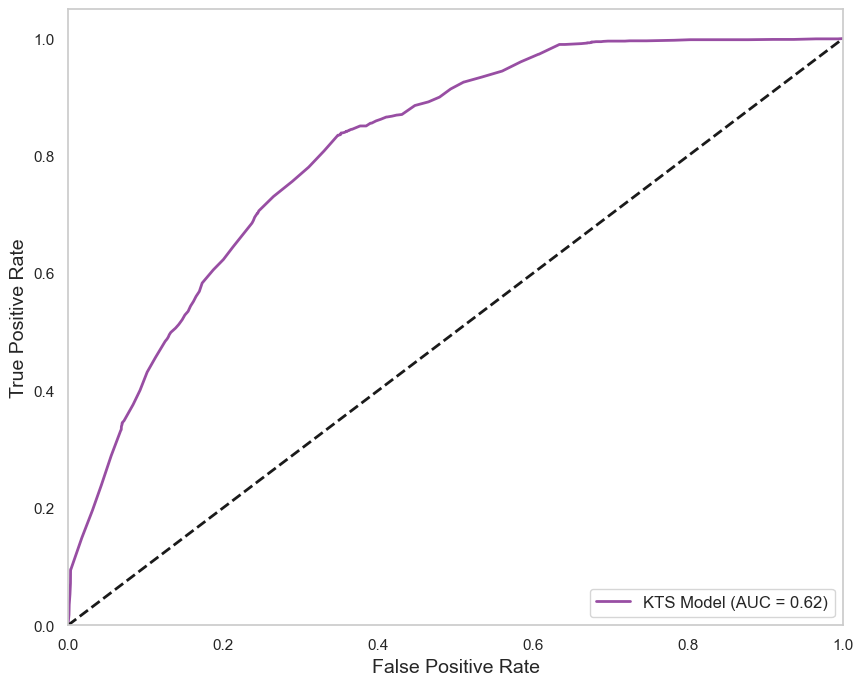

In [30]:
# Import seaborn for the minimal theme
# Calculate the ROC curve
fpr_kts, tpr_kts, _ = roc_curve(y_initialdec_bin.ravel(), y_pred_prob_cv.ravel())

# Plotting the ROC curve for the KTS model
plt.figure(figsize=(10, 8))
plt.plot(fpr_kts, tpr_kts, color='#984ea3', lw=2, label=f'KTS Model (AUC = {roc_auc_kts:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
#plt.title('Receiver Operating Characteristic (ROC) Curve for KTS Model', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(False)  # Remove grid lines
plt.show()

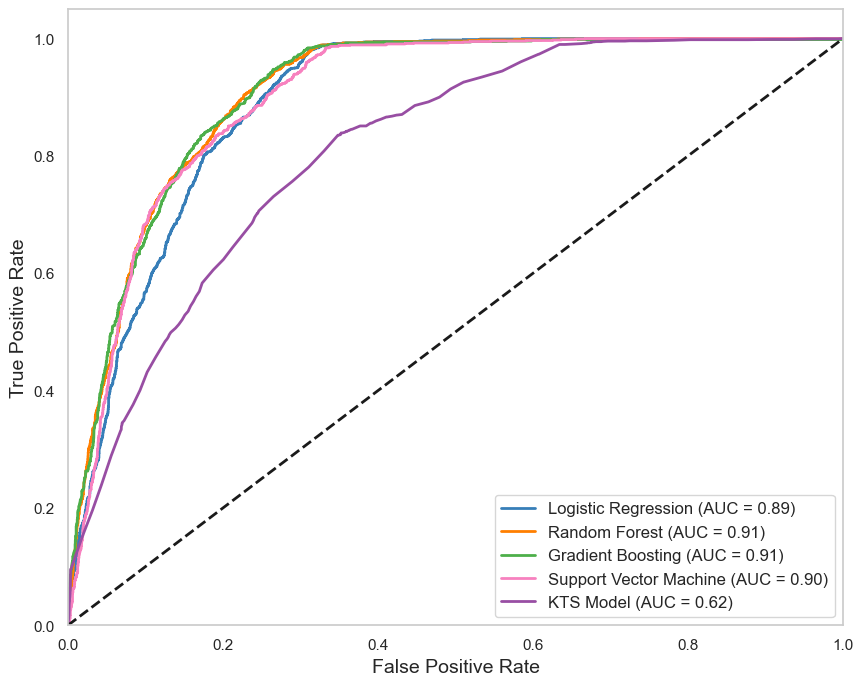

In [34]:
# Plotting the combined ROC curves
plt.figure(figsize=(10, 8))  # Increase figure size
colors = cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#984ea3'])  # Use a colorblind-friendly palette

# Plot ROC curves for classifiers
for (name, color) in zip(classifiers.keys(), colors):
    plt.plot(fpr_dict[name], tpr_dict[name], color=color, lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:0.2f})')

# Plot ROC curve for KTS model
plt.plot(fpr_kts, tpr_kts, color='#984ea3', lw=2, label=f'KTS Model (AUC = {roc_auc_kts:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
#plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(False)  # Add grid lines
plt.show()

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_fscore_support, roc_auc_score, precision_score, recall_score, f1_score
# Statistical Tests to Compare Models
from scipy import stats
# Define a function to calculate metrics for each model
def calculate_metrics(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Retrieve the trained Gradient Boosting model from the classifiers dictionary
random_forest_model = classifiers['Random Forest']

# Prepare the data for the ML model
X_test_ml = preprocessor.transform(X_test)
y_test_ml = y_test.copy()

# Calculate metrics for ML model (using Gradient Boosting as an example)
metrics_ml = calculate_metrics(random_forest_model, X_test_ml, y_test_ml)

# Combine metrics into arrays for statistical tests
metrics_ml_array = np.array(metrics_ml)
metrics_kts_array = np.array([accuracy_kts, precision_kts, recall_kts, f1_score_kts])

# Perform paired t-test
t_stat, p_value_t = stats.ttest_rel(metrics_ml_array, metrics_kts_array)
print(f'Paired t-test p-value: {p_value_t}')

# Perform Wilcoxon signed-rank test
w_stat, p_value_w = stats.wilcoxon(metrics_ml_array, metrics_kts_array)
print(f'Wilcoxon signed-rank test p-value: {p_value_w}')

# Summary of Results
print("\nSummary of Model Performance:")
print(results_df)



Paired t-test p-value: 0.00548460176059818
Wilcoxon signed-rank test p-value: 0.125

Summary of Model Performance:
               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
0     Logistic Regression  0.630091   0.629736  0.630091  0.627832  0.893932   
1           Random Forest  0.688279   0.686693  0.688279  0.683635  0.909413   
2       Gradient Boosting  0.680798   0.678722  0.680798  0.675260  0.909114   
3  Support Vector Machine  0.686617   0.687614  0.686617  0.678296  0.901178   

   CV Mean Accuracy    CV Std                                 CV 95% CI  \
0          0.626831  0.019540  (0.6191719481520589, 0.6344910230093012)   
1          0.675481  0.008160  (0.6722820728686686, 0.6786795991062006)   
2          0.673532  0.013991  (0.6680472381838866, 0.6790160648568885)   
3          0.667996  0.003947   (0.6664492587158926, 0.669543468579477)   

   CV Mean AUC-ROC  CV Std AUC-ROC                         CV 95% CI AUC-ROC  
0         0.791992        0.0

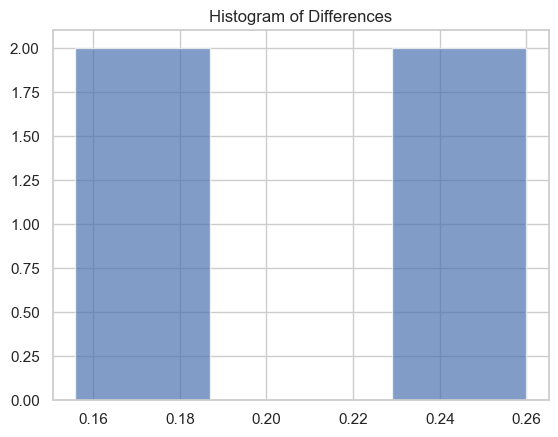

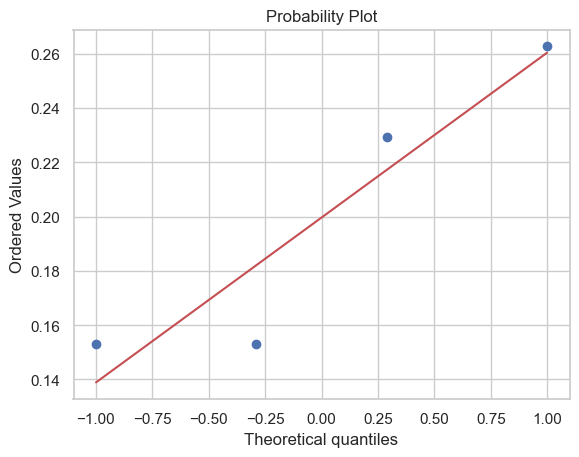

Shapiro-Wilk test p-value: 0.20292937755584717


In [42]:
# Calculate differences
differences = metrics_ml_array - metrics_kts_array

# Plot histogram of differences
plt.hist(differences, bins='auto', alpha=0.7, rwidth=0.85)
plt.title('Histogram of Differences')
plt.show()

# Q-Q plot
stats.probplot(differences, dist="norm", plot=plt)
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(differences)
print(f'Shapiro-Wilk test p-value: {shapiro_test.pvalue}')

In [44]:
import pandas as pd
import sklearn
import statsmodels
import scipy

print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Statsmodels version: {statsmodels.__version__}")
print(f"Scipy version: {scipy.__version__}")

Pandas version: 2.1.3
Scikit-learn version: 1.3.2
Statsmodels version: 0.14.0
Scipy version: 1.11.3


In [72]:
data['mechofinj_str'].value_counts()

mechofinj_str
Fall                     1420
Road Traffic Accident    1400
Blunt Force               685
Stab/Cut                  154
Animal Bite               114
Burn                      114
Other                      73
Poisoning                  34
Gunshot                    11
nan                         4
Name: count, dtype: int64